In this experiment, we do the following:
* Transfer learning using the pre-trained model _Yamnet_ as feature extractor.

Result:
?

Backlog:
* Hyperparameter tuning for the upper layers.

## No hyperparams tuning

Simply replicating Keras example at https://keras.io/examples/audio/uk_ireland_accent_recognition

In [ ]:
%pip install -U -q tensorflow tensorflow_datasets
#apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
%pip install -U -q keras-tuner
%pip install -U -q visualkeras

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import pathlib
import os
from os.path import isfile, join, splitext

import tensorflow as tf
from tensorflow import keras
import tensorflow_io as tfio
import tensorflow_hub as tfhub
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.models import Sequential
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from pydub import AudioSegment
import soundfile as sf
import time
import visualkeras

SAMPLING_RATE = 16000
EPOCHS = 50
BATCH_SIZE = 128
SHUFFLE_SEED = 42
TUNING_DIRECTORY = "model8_tuning_dir"
PROJECT_NAME = "model8_tuning"
MODEL_NAME = "MODEL8"

# Set the seed value for experiment reproducibility.
tf.random.set_seed(SHUFFLE_SEED)
np.random.seed(SHUFFLE_SEED)

2023-01-27 02:23:00.246678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### Prepare Dataset

In [2]:
df_train = pd.read_csv(os.getcwd() + "/data/audio10-aug-train.csv", delimiter= ';')
df_val = pd.read_csv(os.getcwd() + "/data/audio10-aug-val.csv", delimiter=';')
df_test = pd.read_csv(os.getcwd() + "/data/audio10-aug-test.csv", delimiter=';')

# Rewrite file_name to contain file paths
df_train['file_name'] = df_train.apply(
    lambda row: os.path.join(os.getcwd(), 'data/augmented', row['file_name'] + '.wav'), 
    axis=1
)
df_val['file_name'] = df_val.apply(
    lambda row: os.path.join(os.getcwd(), 'data/augmented', row['file_name'] + '.wav'), 
    axis=1
)
df_test['file_name'] = df_test.apply(
    lambda row: os.path.join(os.getcwd(), 'data/augmented', row['file_name'] + '.wav'), 
    axis=1
)

class_names = df_train['class_labels'].unique()
# lang_idxs = range(len(class_names))
# class_dict = dict(zip(class_names, lang_idxs))
print(f"Success loading dataset! There are {len(class_names)} classes.")  # should be 53 classes


Success loading dataset! There are 53 classes.


In [3]:
yamnet_model = tf.saved_model.load('./yamnet_1')

2023-01-27 02:23:38.178355: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)
    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    # labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(df_x, df_y, batch_size=64):
    # Convert the labels into numbers -- no longer necessary since we're targetting the class_labels column
    # dataframe['native_langs'] = dataframe.apply(
    #     lambda row: class_dict[row['native_langs']],
    #     axis=1
    # )

    dataset = tf.data.Dataset.from_tensor_slices((df_x, df_y))

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [5]:
X_train = df_train.iloc[:, :-1]
X_val = df_val.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]
y_train = df_train['class_labels']
y_val = df_val['class_labels']
y_test = df_test['class_labels']

print(f'''
Splitting success!
X_train: {len(X_train)}, y_train: {len(y_train)}
X_val: {len(X_val)}, y_val: {len(y_val)}
X_test: {len(X_test)}, y_test: {len(y_test)}
''')

train_ds = dataframe_to_dataset(X_train['file_name'], y_train)
val_ds = dataframe_to_dataset(X_val['file_name'], y_val)
test_ds = dataframe_to_dataset(X_test['file_name'], y_test)

print('Conversion to dataset success!')


Splitting success!
X_train: 10400, y_train: 10400
X_val: 1165, y_val: 1165
X_test: 1165, y_test: 1165

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-01-27 02:23:53.424129: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


Conversion to dataset success!


In [6]:
class_counts = tf.zeros(shape=(len(class_names),), dtype=tf.int32)

for x, y in iter(train_ds):
    class_counts = class_counts + tf.math.bincount(
        tf.cast(tf.math.argmax(y, axis=1), tf.int32), minlength=len(class_names)
    )

class_weight = {
    i: tf.math.reduce_sum(class_counts).numpy() / class_counts[i].numpy()
    for i in range(len(class_counts))
}

print(class_weight)

{0: 195.9115529653754, 1: 80.72806893629044, 2: 10.508707085195196, 3: 103.04255319148936, 4: 224.3714173537495, 5: 133.08663251047975, 6: 70.2920049200492, 7: 196.58548331613346, 8: 52.56383370125092, 9: 4.814034200994019, 10: 130.68236908300938, 11: 54.66035389765663, 12: 176.9817280891917, 13: 30.569915480902964, 14: 63.4477628511158, 15: 137.34054313866858, 16: 147.0218677643427, 17: 226.95552025416998, 18: 270.2004728132388, 19: 80.2857544254004, 20: 160.30126227208976, 21: 173.38410194174756, 22: 66.18112333526346, 23: 52.87509252405626, 24: 231.17880258899677, 25: 24.732710118583917, 26: 200.16602451838878, 27: 101.18165722379604, 28: 14.803875346475662, 29: 251.4183897932248, 30: 181.3052030456853, 31: 222.62329567588625, 32: 123.18904936408708, 33: 188.23254281949934, 34: 70.74449121069571, 35: 39.46098605165032, 36: 178.52983442674164, 37: 112.89490320031608, 38: 30.702949551388816, 39: 136.2923920820415, 40: 206.7561505065123, 41: 9.87069918474506, 42: 121.46099893730074, 43

In [7]:
from keras import backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
def build_and_compile_model(d1, d2, d3, d4, learning):
    inputs = keras.layers.Input(shape=(1024), name="embedding")
    x = visualkeras.SpacingDummyLayer(spacing=50)(inputs)

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(x)
    x = keras.layers.Dropout(d1, name="dropout_1")(x)
    x = visualkeras.SpacingDummyLayer(spacing=50)(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(d2, name="dropout_2")(x)
    x = visualkeras.SpacingDummyLayer(spacing=50)(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(d3, name="dropout_3")(x)
    x = visualkeras.SpacingDummyLayer(spacing=50)(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(d4, name="dropout_4")(x)
    x = visualkeras.SpacingDummyLayer(spacing=50)(x)

    outputs = keras.layers.Dense(len(class_names), activation="softmax", name="ouput")(
        x
    )

    model = keras.Model(inputs=inputs, outputs=outputs, name="accent_recognition")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", get_f1],
    )

    return model

In [9]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


def evaluate_model(mod):
    train_loss, train_acc, train_f1 = mod.evaluate(train_ds)
    valid_loss, valid_acc, valid_f1 = mod.evaluate(val_ds)
    test_loss, test_acc, test_f1 = mod.evaluate(test_ds)

    print(f'train_loss {train_loss:.4f}, train_acc {train_acc:.4f}, train_f1 {train_f1:.4f}')
    print(f'valid_loss {valid_loss:.4f}, valid_acc {valid_acc:.4f}, valid_f1 {valid_f1:.4f}')
    print(f'test_loss {test_loss:.4f}, test_acc {test_acc:.4f}, test_f1 {test_f1:.4f}')
    # print("train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
    #     d_prime(train_auc), d_prime(valid_auc)
    # ))

In [10]:
def show_performance_plot(history):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

    axs[0].plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training")
    axs[0].plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation")
    axs[0].set_xlabel("Epochs")
    axs[0].set_title("Training & Validation Accuracy")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(range(len(history.history["loss"])), history.history["loss"], label="Training")
    axs[1].plot(range(len(history.history["val_loss"])), history.history["val_loss"], label="Validation")
    axs[1].set_xlabel("Epochs")
    axs[1].set_title("Training & Validation Loss")
    axs[1].legend()
    axs[1].grid(True)

    plt.show()

### Build and train model

In [18]:
model = build_and_compile_model(.8, .8, .8, .8, 1.9644e-5)
model.summary()

Model: "accent_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 1024)]            0         
                                                                 
 spacing_dummy_layer_5 (Spac  (None, 1024)             0         
 ingDummyLayer)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 spacing_dummy_layer_6 (Spac  (None, 256)              0         
 ingDummyLayer)                                                  
                                                                 
 dense_2 (Dense)             (None, 384)        

In [19]:
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

model_checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_NAME + ".h5", monitor="val_accuracy", save_best_only=True
)

tensorboard_cb = keras.callbacks.TensorBoard(
    os.path.join(os.curdir, "logs", model.name)
)

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
8930/8930 - 161s - loss: 216.1452 - accuracy: 0.0600 - get_f1: 0.0068 - val_loss: 3.9617 - val_accuracy: 0.2226 - val_get_f1: 0.0000e+00 - 161s/epoch - 18ms/step
Epoch 2/50
8930/8930 - 147s - loss: 215.2134 - accuracy: 0.2010 - get_f1: 0.1238 - val_loss: 3.9613 - val_accuracy: 0.2228 - val_get_f1: 0.0000e+00 - 147s/epoch - 16ms/step
Epoch 3/50
8930/8930 - 95s - loss: 210.3774 - accuracy: 0.2053 - get_f1: 0.0701 - val_loss: 3.9584 - val_accuracy: 0.2228 - val_get_f1: 0.0000e+00 - 95s/epoch - 11ms/step
Epoch 4/50
8930/8930 - 91s - loss: 207.1306 - accuracy: 0.2112 - get_f1: 0.0022 - val_loss: 3.9578 - val_accuracy: 0.2228 - val_get_f1: 0.0000e+00 - 91s/epoch - 10ms/step
Epoch 5/50
8930/8930 - 85s - loss: 206.7547 - accuracy: 0.2197 - get_f1: 0.0060 - val_loss: 3.9586 - val_accuracy: 0.2228 - val_get_f1: 0.0000e+00 - 85s/epoch - 9ms/step
Epoch 6/50
8930/8930 - 83s - loss: 206.0410 - accuracy: 0.2248 - get_f1: 0.0081 - val_loss: 3.9594 - val_accuracy: 0.2228 - val_get_f1: 0.0000

In [20]:
evaluate_model(model)

1068/1068 [==============================] - 5s 4ms/step - loss: 3.9583 - accuracy: 0.2222 - get_f1: 0.0000e+00
train_loss 3.9587, train_acc 0.2077, train_f1 0.0000
valid_loss 3.9584, valid_acc 0.2228, valid_f1 0.0000
test_loss 3.9583, test_acc 0.2222, test_f1 0.0000


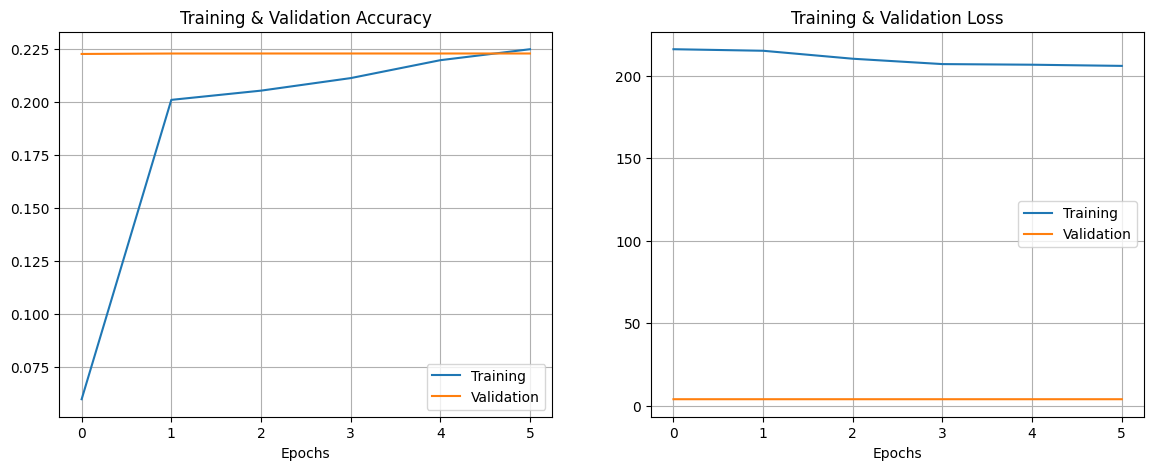

In [21]:
show_performance_plot(history)

### Visualize network architecture

In [142]:
def show_network_graph(filename):
    # font = ImageFont.truetype("/Users/georgioschristopoulos/PycharmProjects/CNNAudio/data/arial.ttf", 32)  # using comic sans is strictly prohibited!
    # visualkeras.layered_view(model,scale_xy=75,font=font, scale_z=1, max_z=1000, legend=True).show()  # display using your system viewer
    # visualkeras.layered_view(model,scale_xy=75,font=font, scale_z=1, max_z=1000, legend=True, to_file='output.png') # write to disk
    # visualkeras.layered_view(model, to_file='output.png').show()

    visualkeras.layered_view(model,scale_xy=75, scale_z=1, max_z=1000, legend=True).show()  # display using your system viewer
    visualkeras.layered_view(model,scale_xy=75, scale_z=1, max_z=1000, legend=True, to_file=filename) # write to disk
    visualkeras.layered_view(model, to_file=filename).show()

In [143]:
show_network_graph('network-graph-14.png')

### Testing with IDEA dataset

In [35]:
idea_test = pd.read_csv(os.getcwd() + "/data/idea_audio.csv", delimiter=',')

# Rewrite file_name to contain file paths
idea_test['file_name'] = idea_test.apply(
    lambda row: os.path.join(os.getcwd(), 'data/IDEA_audio_wav', row['file_name'] + '.wav'), 
    axis=1
)

idea_class_names = idea_test['class_labels'].unique()
# lang_idxs = range(len(class_names))
# class_dict = dict(zip(class_names, lang_idxs))

print(f"Success loading dataset! There are {len(idea_class_names)} classes.")  # 53 classes in the downsampled dataset

Success loading dataset! There are 8 classes.


In [36]:
X_test = idea_test.iloc[:, :-1]
y_test = idea_test['class_labels']

print(f'''
Splitting success!
X_test: {len(X_test)}, y_test: {len(y_test)}
''')

test_idea_ds = dataframe_to_dataset(X_test['file_name'], y_test)

print('Conversion to dataset success!')


Splitting success!
X_test: 93, y_test: 93

Conversion to dataset success!


In [37]:
test_loss, test_acc, test_f1 = model.evaluate(test_idea_ds)

print(f'test_loss {test_loss:.4f}, test_acc {test_acc:.4f}, test_f1 {test_f1:.4f}')

853/853 [==============================] - 233s 257ms/step - loss: 1.1135 - accuracy: 0.0000e+00 - get_f1: 0.0000e+00
test_loss 1.1135, test_acc 0.0000, test_f1 0.0000


### Results

**Graph 1**
- All middle layers have 0.4 dropout. 
- Adam optimizer, learning rate 1.9644e-5. 
- Training time 58m. 

![alt text](results/graph1.png "Graph1")

**Graph 2**
- All middle layers have 0.4 dropout. 
- Adadelta optimizer, learning rate 1.9644e-5. 
- Training time 100m. 

![](results/graph2.png "Graph2")

**Graph 3**
- 0.3 dropout
- Adadelta 1.9644e-5
- Training 97m

![](results/graph3.png "Graph 3")

**Graph 4**
- 0.8 dropout
- Adam 1.9644e-5
- Training 23m

![](results/graph4.png "Graph 4")

**Graph 10**
- 0.8 dropout
- Adadelta 1.9644e-5
- Training 97m

![](results/graph10.png "Graph 10")

**Graph 11**
- 0.8 dropout
- Adadelta 0.001
- Training 10m

![](results/graph11.png "Graph 11")

**Graph 14**
- 0.8 dropout
- Adadelta 0.01
- Training 8m

![](results/graph14.png "Graph 14")

**Graph 12**
- Dropout [0.3, 0.3, 0.25, 0.25]
- Adadelta 0.001
- Training 7m

![](results/graph12.png "Graph 12")

**Graph 13**
- Dropout [0.25, 0.25, 0.15, 0.15]
- Adadelta 0.001
- Training 8m

![](results/graph13.png "Graph 13")

**Graph 5**
- Dropout [.8, .8, .5, .5]
- Adam 1.9644e-5
- Training 41m

![](results/graph5.png "Graph 5")

**Graph 6**
- dropout [.5 .5 .8 .8]
- Adam 1.9644e-5
- Training 25m

![](results/graph6.png "Graph 6")

**Graph 7**
- Dropout [.5, .5, .8, .8]
- Adam 1.9644e-5
- No class weights
- Training 40m

![](results/graph7.png "Graph 7")

**Graph 8**
- 0.8 dropout
- Adam 1.9644e-5
- No class weights
- training 29m

![](results/graph8.png "Graph 8")

**Graph 9**
- dropout .25
- Adadelta .001
- training 122m

![](results/graph9.png "Graph 9")

**Graph 15**
- dropout .3 .3 .8 .8
- Adam 0.01
- Training 15m

![](results/graph15.png "Graph 15")
